In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt

# complex
from deepdeform_debug.layers.deformation_layer import ImNet, NeuralFlowModel, NeuralFlowDeformer
from deepdeform_debug.layers.pointnet_layer import PointNetEncoder
from deepdeform_debug.layers.chamfer_layer import ChamferDistKDTree

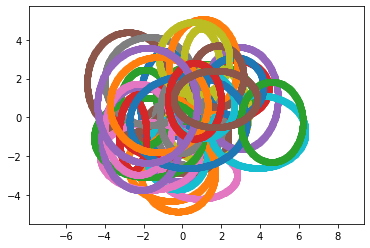

In [2]:
# initial set of points
theta = torch.linspace(0, 2*np.pi, 361)[:-1]

# source points
x0 = torch.stack((torch.cos(theta),
                  torch.sin(theta)), axis=-1)  # [n, 3]

torch.manual_seed(2)
# create variations of the source
all_shapes = [x0]
ns = 36
for i in range(ns-1):
    scale = torch.randn(2) * 0.5 + 2
    shift = torch.randn(2) * 2
    x_new = x0 * scale + shift
    all_shapes.append(x_new)
    
x_all = torch.stack(all_shapes, dim=0)  # [nshapes, npoints, 3]

plt.figure()
for i in range(ns):
    plt.scatter(x_all[i, :, 0], x_all[i, :, 1], label='x_{}'.format(i))
plt.axis('equal')
# plt.legend()
plt.show()

## test encoderless learning

In [3]:
# dataloader for loading the shapes
class DemoLoader(Dataset):
    """Pytorch Dataset base for loading demo shape pairs.
    """
    def __init__(self, x_all):
        """Initialize dataloader.
        
        Args:
          x_all: [#shapes, #points, 3] tensor of all shapes
        """
        self.x_all = x_all
    
    def __len__(self):
        return int(0.5 * self.n_shapes * (self.n_shapes - 1))
    
    @property
    def n_shapes(self):
        return self.x_all.shape[0]
    
    @staticmethod
    def _idx_to_combinations(idx):
        """Translate a 1d index to a pair of indices from the combinations."""
        idx = idx + 1
        i = np.ceil((-1+np.sqrt(1+8*idx)) / 2)
        j = idx - (i * (i-1)) / 2
        return int(i), int(j)-1
    
    def __getitem__(self, idx):
        """Get a random pair of shapes corresponding to idx.
        Args:
          idx: int, index of the shape pair to return. must be smaller than len(self).
        Returns:
          verts_i: [npoints, 3] float tensor for point samples from the first shape.
          verts_j: [npoints, 3] float tensor for point samples from the second shape.
        """
        i, j = self._idx_to_combinations(idx)
        return i, j, self.x_all[i], self.x_all[j]


demo_dataset = DemoLoader(x_all)
# vi, vj = demo_dataset[0]
# print("vi shape: ", vi.shape, "vj shape: ", vj.shape)
print("dataset # shapes: {}, # combinations: {}".format(demo_dataset.n_shapes, len(demo_dataset)))
# bs = len(demo_dataset)
bs = min(32, len(demo_dataset))
# demo_sampler = RandomSampler(demo_dataset, replacement=True, num_samples=bs) # min(ns, 16))
demo_sampler = RandomSampler(demo_dataset, replacement=False)
# demo_loader = DataLoader(demo_dataset, batch_size=min(len(demo_dataset), 8), shuffle=False, drop_last=True,
#                          sampler=demo_sampler, num_workers=min(len(demo_dataset), 8), pin_memory=True)
demo_loader = DataLoader(demo_dataset, batch_size=bs, shuffle=False, drop_last=True,
                         sampler=demo_sampler, num_workers=bs, pin_memory=True)
for i, j, vi, vj in demo_loader:
    print(i.shape, j.shape, "batched vi shape: ", vi.shape, "batched vj shape: ", vj.shape)
    break

dataset # shapes: 36, # combinations: 630
torch.Size([32]) torch.Size([32]) batched vi shape:  torch.Size([32, 360, 2]) batched vj shape:  torch.Size([32, 360, 2])


In [6]:
optim_with_adjoint_gradient = False
method = 'rk4'

device = torch.device('cuda')

latent_size = 64
deformer = NeuralFlowDeformer(dim=2, latent_size=latent_size, f_nlayers=6, f_width=64, s_nlayers=4, s_width=32, method=method, nonlinearity='leakyrelu', arch='imnet', 
                              adjoint=optim_with_adjoint_gradient, rtol=1e-4, conformal=False)
deformer.to(device)
lats = torch.nn.Parameter(torch.randn(ns, latent_size), requires_grad=True)


chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
crit = torch.nn.MSELoss()
# by wrapping encoder into deformer, no need to add encoder parameters individually
optim = torch.optim.Adam(list(deformer.parameters()) + [lats], lr=1e-3)

lats = lats.to(device)

deformer.train()


step = 0
for i in range(400): # train for 100 epochs
    for ind, (ii, jj, x_src, x_tar) in enumerate(demo_loader):
        x_src = x_src.to(device)
        x_tar = x_tar.to(device)
        # compute gradients using odeint regular
        optim.zero_grad()
        
        # because this is a 2d demo, need to pad zeros for 3rd dimension
        x_pad = torch.zeros([x_src.shape[0], x_src.shape[1], 1], device=x_src.device)
        x_src_pad = torch.cat([x_src, x_pad], dim=-1)
        x_tar_pad = torch.cat([x_tar, x_pad], dim=-1)
        
        l_src = lats[ii]
        l_tar = lats[jj]

        x_src_ = torch.cat([x_src, x_tar], dim=0)
        x_tar_ = torch.cat([x_tar, x_src], dim=0)
        l_src_ = torch.cat([l_src, l_tar], dim=0)
        l_tar_ = torch.cat([l_tar, l_src], dim=0)

        # okay to batch. not okay to call deformer twice (somehow breaks the gradients from adjoint solver)
        x_s2t = deformer(x_src_, l_src_, l_tar_)

        _, _, dist_s2t = chamfer_dist(x_s2t, x_tar_)
    
        loss = crit(dist_s2t, torch.zeros_like(dist_s2t))
                
        loss.backward()

        optim.step()
        
        if step % 25 == 0:
            print("Iter {:3d} Loss {:3f} Beta {:3f}".format(step, loss.item(), deformer.net.beta.item()))
        step += 1

Iter   0 Loss 5.627739 Beta 0.099000
Iter  25 Loss 2.527228 Beta 0.110421
Iter  50 Loss 1.965888 Beta 0.109701
Iter  75 Loss 1.299451 Beta 0.109636
Iter 100 Loss 0.633372 Beta 0.110497
Iter 125 Loss 1.269403 Beta 0.110911
Iter 150 Loss 0.919254 Beta 0.110940
Iter 175 Loss 0.660774 Beta 0.112524
Iter 200 Loss 0.578264 Beta 0.113155
Iter 225 Loss 0.457690 Beta 0.114740
Iter 250 Loss 0.402540 Beta 0.114981
Iter 275 Loss 0.455683 Beta 0.115081
Iter 300 Loss 0.383621 Beta 0.115395
Iter 325 Loss 0.284550 Beta 0.115859
Iter 350 Loss 0.379148 Beta 0.115827
Iter 375 Loss 0.484676 Beta 0.116650
Iter 400 Loss 0.276511 Beta 0.117389
Iter 425 Loss 0.169455 Beta 0.117535
Iter 450 Loss 0.174351 Beta 0.117625
Iter 475 Loss 0.278227 Beta 0.117235
Iter 500 Loss 0.201666 Beta 0.117615
Iter 525 Loss 0.221193 Beta 0.117438
Iter 550 Loss 0.222829 Beta 0.117563
Iter 575 Loss 0.207613 Beta 0.117343
Iter 600 Loss 0.217992 Beta 0.117692
Iter 625 Loss 0.130388 Beta 0.118312
Iter 650 Loss 0.150607 Beta 0.118417
I

KeyboardInterrupt: 

In [ ]:
# visualize source and target
x_src_ = x_src.detach().cpu().numpy()
x_tar_ = x_tar.detach().cpu().numpy()
s = x_s2t.shape[0]
hs = int(s/2)
x_s2t_ = x_s2t[:hs].detach().cpu().numpy()
x_t2s_ = x_s2t[hs:].detach().cpu().numpy()

idx = 1

plt.figure(figsize=(8,8))
plt.scatter(x_src_[idx, :, 0], x_src_[idx, :, 1], label='source')
plt.scatter(x_tar_[idx, :, 0], x_tar_[idx, :, 1], label='target')
plt.scatter(x_s2t_[idx, :, 0], x_s2t_[idx, :, 1], label='src2tar')
plt.scatter(x_t2s_[idx, :, 0], x_t2s_[idx, :, 1], label='tar2src')

# n = x_src_.shape[1]
# for i in range(n):
#     plt.plot([x_src_[idx, i, 0], x_s2t_[idx, i, 0]], [x_src_[idx, i, 1], x_s2t_[idx, i, 1]], color='black')
    
# visualize flow field
t = 0.5
r = 15
l = torch.linspace(-8, 8, r)
xy = torch.stack(torch.meshgrid(l, l), dim=-1)  # [50, 50, 2]
xy = xy.reshape([1, -1, 2]).cuda()

deformer.net.update_latents(l_src[idx:idx+1], l_tar[idx:idx+1])
v = deformer.net(t, xy).detach().cpu().numpy()
# plt.figure(figsize=(8, 8))
xy = xy.detach().cpu().numpy()
plt.quiver(xy[0, :, 0], xy[0, :, 1], v[0, :, 0], v[0, :, 1])
# plt.show()
    
plt.axis('equal')
plt.legend()
plt.show()

## Previous version that works

In [ ]:
# dataloader for loading the shapes
class DemoLoader(Dataset):
    """Pytorch Dataset base for loading demo shape pairs.
    """
    def __init__(self, x_all):
        """Initialize dataloader.
        
        Args:
          x_all: [#shapes, #points, 3] tensor of all shapes
        """
        self.x_all = x_all
    
    def __len__(self):
        return int(0.5 * self.n_shapes * (self.n_shapes - 1))
    
    @property
    def n_shapes(self):
        return self.x_all.shape[0]
    
    @staticmethod
    def _idx_to_combinations(idx):
        """Translate a 1d index to a pair of indices from the combinations."""
        idx = idx + 1
        i = np.ceil((-1+np.sqrt(1+8*idx)) / 2)
        j = idx - (i * (i-1)) / 2
        return int(i), int(j)-1
    
    def __getitem__(self, idx):
        """Get a random pair of shapes corresponding to idx.
        Args:
          idx: int, index of the shape pair to return. must be smaller than len(self).
        Returns:
          verts_i: [npoints, 3] float tensor for point samples from the first shape.
          verts_j: [npoints, 3] float tensor for point samples from the second shape.
        """
        i, j = self._idx_to_combinations(idx)
        return self.x_all[i], self.x_all[j]

In [ ]:
demo_dataset = DemoLoader(x_all)
vi, vj = demo_dataset[0]
print("vi shape: ", vi.shape, "vj shape: ", vj.shape)
print("dataset # shapes: {}, # combinations: {}".format(demo_dataset.n_shapes, len(demo_dataset)))
# bs = len(demo_dataset)
bs = min(8, len(demo_dataset))
# demo_sampler = RandomSampler(demo_dataset, replacement=True, num_samples=bs) # min(ns, 16))
demo_sampler = RandomSampler(demo_dataset, replacement=False)
# demo_loader = DataLoader(demo_dataset, batch_size=min(len(demo_dataset), 8), shuffle=False, drop_last=True,
#                          sampler=demo_sampler, num_workers=min(len(demo_dataset), 8), pin_memory=True)
demo_loader = DataLoader(demo_dataset, batch_size=bs, shuffle=False, drop_last=True,
                         sampler=demo_sampler, num_workers=bs, pin_memory=True)
for vi, vj in demo_loader:
    print("batched vi shape: ", vi.shape, "batched vj shape: ", vj.shape)
    break

## Use containerized deformer along with encoder

In [ ]:
optim_with_adjoint_gradient = True
method = 'dopri5'

device = torch.device('cuda')

latent_size = 32
encoder = PointNetEncoder(nf=32, in_features=3, out_features=latent_size, dropout_prob=0.0, norm_type='none', nonlinearity='relu')
deformer = NeuralFlowDeformer(dim=2, latent_size=latent_size, f_nlayers=6, f_width=64, s_nlayers=4, s_width=32, method=method, nonlinearity='leakyrelu', arch='imnet', 
                              adjoint=optim_with_adjoint_gradient, rtol=1e-4, conformal=False)

# this is an awkward workaround to get gradients for encoder via adjoint solver
deformer.add_encoder(encoder)
deformer.to(device)
encoder = deformer.net.encoder

chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
crit = torch.nn.MSELoss()
# by wrapping encoder into deformer, no need to add encoder parameters individually
optim = torch.optim.Adam(list(deformer.parameters()), lr=1e-3)

encoder.train()
deformer.train()

step = 0
for i in range(100): # train for 100 epochs
    for ind, (x_src, x_tar) in enumerate(demo_loader):
        x_src = x_src.to(device)
        x_tar = x_tar.to(device)
        # compute gradients using odeint regular
        optim.zero_grad()
        
        # because this is a 2d demo, need to pad zeros for 3rd dimension
        x_pad = torch.zeros([x_src.shape[0], x_src.shape[1], 1], device=x_src.device)
        x_src_pad = torch.cat([x_src, x_pad], dim=-1)
        x_tar_pad = torch.cat([x_tar, x_pad], dim=-1)
        
        l_src = encoder(x_src_pad)
        l_tar = encoder(x_tar_pad)

        x_src_ = torch.cat([x_src, x_tar], dim=0)
        x_tar_ = torch.cat([x_tar, x_src], dim=0)
        l_src_ = torch.cat([l_src, l_tar], dim=0)
        l_tar_ = torch.cat([l_tar, l_src], dim=0)

        # okay to batch. not okay to call deformer twice (somehow breaks the gradients from adjoint solver)
        x_s2t = deformer(x_src_, l_src_, l_tar_)

        _, _, dist_s2t = chamfer_dist(x_s2t, x_tar_)
#         dist_s2t = torch.norm(x_tar_ - x_s2t, dim=-1)
    
        loss = crit(dist_s2t, torch.zeros_like(dist_s2t))
                
        loss.backward()

        optim.step()
        
        if step % 10 == 0:
            print("Iter {:3d} Loss {:3f} Beta {:3f}".format(step, loss.item(), deformer.net.beta.item()))
        step += 1

In [ ]:
# visualize source and target
x_src_ = x_src.detach().cpu().numpy()
x_tar_ = x_tar.detach().cpu().numpy()
s = x_s2t.shape[0]
hs = int(s/2)
x_s2t_ = x_s2t[:hs].detach().cpu().numpy()
x_t2s_ = x_s2t[hs:].detach().cpu().numpy()

idx = 5

plt.figure(figsize=(8,8))
plt.scatter(x_src_[idx, :, 0], x_src_[idx, :, 1], label='source')
plt.scatter(x_tar_[idx, :, 0], x_tar_[idx, :, 1], label='target')
plt.scatter(x_s2t_[idx, :, 0], x_s2t_[idx, :, 1], label='src2tar')
plt.scatter(x_t2s_[idx, :, 0], x_t2s_[idx, :, 1], label='tar2src')

# n = x_src_.shape[1]
# for i in range(n):
#     plt.plot([x_src_[idx, i, 0], x_s2t_[idx, i, 0]], [x_src_[idx, i, 1], x_s2t_[idx, i, 1]], color='black')
    
# visualize flow field
t = 0.5
r = 15
l = torch.linspace(-5, 4, r)
xy = torch.stack(torch.meshgrid(l, l), dim=-1)  # [50, 50, 2]
xy = xy.reshape([1, -1, 2]).cuda()

deformer.net.update_latents(l_src[idx:idx+1], l_tar[idx:idx+1])
v = deformer.net(t, xy).detach().cpu().numpy()
# plt.figure(figsize=(8, 8))
xy = xy.detach().cpu().numpy()
plt.quiver(xy[0, :, 0], xy[0, :, 1], v[0, :, 0], v[0, :, 1])
# plt.show()
    
plt.axis('equal')
plt.legend()
plt.show()

## Previous code that converges with adjoint

In [ ]:
# # initial set of points
# theta = torch.linspace(0, 2*np.pi, 361)[:-1]

# # source points
# x_src = torch.stack((torch.cos(theta),
#                      torch.sin(theta)), axis=-1)  # [n, 3]

# # target points
# x_tar = x_src * 3 + 2

# plt.figure()
# plt.scatter(x_src[:, 0], x_src[:, 1], label='src')
# plt.scatter(x_tar[:, 0], x_tar[:, 1], label='tar')
# plt.axis('equal')
# plt.legend()
# plt.show()


optim_with_adjoint_gradient = True
method = 'dopri5'

device = torch.device('cuda')

latent_size = 32
deformer = NeuralFlowDeformer(dim=2, latent_size=latent_size, f_nlayers=6, f_width=32, s_nlayers=3, s_width=3, method=method, nonlinearity='elu', arch='imnet', 
                              adjoint=optim_with_adjoint_gradient, rtol=1e-5).to(device)
encoder = PointNetEncoder(nf=32, in_features=3, out_features=latent_size).to(device)

chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
crit = torch.nn.MSELoss()
optim = torch.optim.Adam(list(deformer.parameters()), lr=1e-3)

def integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=False):
    optim.zero_grad()
    deformer.adjoint = use_adjoint
    with torch.no_grad():
        encoder.eval()
        x_src_pad = torch.cat([x_src, torch.zeros([x_src.shape[0], x_src.shape[1], 1], device=x_src.device)], dim=-1)
        x_tar_pad = torch.cat([x_tar, torch.zeros([x_tar.shape[0], x_tar.shape[1], 1], device=x_tar.device)], dim=-1)
        l_src = encoder(x_src_pad)
        l_tar = encoder(x_tar_pad)
        
    x_s2t = deformer(x_src, l_src, l_tar)
#     x_t2s = deformer(x_tar, l_tar, l_src)
    _, _, dist_s2t = chamfer_dist(x_s2t, x_tar)
#     _, _, dist_t2s = chamfer_dist(x_t2s, x_src)
    loss_s2t = crit(dist_s2t, torch.zeros_like(dist_s2t))
#     loss_t2s = crit(dist_t2s, torch.zeros_like(dist_t2s))
#     loss = loss_s2t+loss_t2s
    loss = loss_s2t
    loss.backward()
        
    return x_s2t, loss, optim
    
for i in range(200):    
    for ind, (x_src, x_tar) in enumerate(demo_loader):
        x_src = x_src.to(device)
        x_tar = x_tar.to(device)
        # compute gradients using odeint regular
        x_s2t_reg, loss, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=optim_with_adjoint_gradient)

        optim.step()
    
    print("Iter {:3d} Loss {:3f}".format(i, loss.item()))


In [ ]:
# # initial set of points
# theta = torch.linspace(0, 2*np.pi, 361)[:-1]

# # source points
# x_src = torch.stack((torch.cos(theta),
#                      torch.sin(theta)), axis=-1)  # [n, 3]

# # target points
# x_tar = x_src * 3 + 2

# plt.figure()
# plt.scatter(x_src[:, 0], x_src[:, 1], label='src')
# plt.scatter(x_tar[:, 0], x_tar[:, 1], label='tar')
# plt.axis('equal')
# plt.legend()
# plt.show()


# optim_with_adjoint_gradient = True
# method = 'dopri5'

# device = torch.device('cuda')

# latent_size = 32
# deformer = NeuralFlowDeformer(dim=2, latent_size=latent_size, f_nlayers=6, f_width=32, s_nlayers=3, s_width=3, method=method, nonlinearity='elu', arch='imnet', 
#                               adjoint=optim_with_adjoint_gradient, rtol=1e-5).to(device)
# encoder = PointNetEncoder(nf=32, in_features=3, out_features=latent_size).to(device)

# chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
# crit = torch.nn.MSELoss()
# optim = torch.optim.Adam(list(deformer.parameters()), lr=1e-3)
# x_src = x_src.to(device)
# x_tar = x_tar.to(device)

# def integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=False):
#     optim.zero_grad()
#     deformer.adjoint = use_adjoint
#     with torch.no_grad():
#         encoder.eval()
#         x_src_pad = torch.cat([x_src, torch.zeros([x_src.shape[0], 1], device=x_src.device)], dim=-1)
#         x_tar_pad = torch.cat([x_tar, torch.zeros([x_tar.shape[0], 1], device=x_tar.device)], dim=-1)
#         x_src_tar_pad = torch.stack([x_src_pad, x_tar_pad], dim=0)
#         x_src_tar = torch.stack([x_src, x_tar], dim=0)
#         l_src_tar = encoder(x_src_tar_pad)
        
#     x_s2t = deformer(x_src_tar, l_src_tar, l_src_tar[[1, 0]])
#     _, _, dist = chamfer_dist(x_s2t, x_src_tar[[1, 0]])
#     loss = crit(dist, torch.zeros_like(dist))
    
#     loss.backward()
        
#     return x_s2t, loss, optim
    
# for i in range(200):    
#     # compute gradients using odeint regular
#     x_s2t_reg, loss, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=optim_with_adjoint_gradient)

#     optim.step()
    
#     print("Iter {:3d} Loss {:3f}".format(i, loss.item()))


In [ ]:
x_src_ = x_src.detach().cpu().numpy()
x_tar_ = x_tar.detach().cpu().numpy()
x_s2t_reg_ = x_s2t_reg[0].detach().cpu().numpy()
x_t2s_reg_ = x_s2t_reg[1].detach().cpu().numpy()

plt.figure()
plt.scatter(x_src_[:, 0], x_src_[:, 1], label='source')
plt.scatter(x_tar_[:, 0], x_tar_[:, 1], label='target')
plt.scatter(x_s2t_reg_[:, 0], x_s2t_reg_[:, 1], label='src2tar')
plt.scatter(x_t2s_reg_[:, 0], x_t2s_reg_[:, 1], label='tar2src')
plt.axis('equal')
plt.legend()
plt.show()

## Previos testing code

In [ ]:
# # initial set of points
# theta = torch.linspace(0, 2*np.pi, 361)[:-1]

# # source points
# x_src = torch.stack((torch.cos(theta),
#                      torch.sin(theta)), axis=-1)  # [n, 3]

# # target points
# x_tar = x_src * 3 + 2

# plt.figure()
# plt.scatter(x_src[:, 0], x_src[:, 1], label='src')
# plt.scatter(x_tar[:, 0], x_tar[:, 1], label='tar')
# plt.axis('equal')
# plt.legend()
# plt.show()

# # class ODEFunc(nn.Module):

# #     def __init__(self):
# #         super(ODEFunc, self).__init__()
# #         self.net = ImNet(dim=2, in_features=1, out_features=2, nonlinearity='elu')
    
# #         for m in self.net.modules():
# #             if isinstance(m, nn.Linear):
# #                 nn.init.normal_(m.weight, mean=0, std=0.1)
# #                 nn.init.constant_(m.bias, val=0)

# #     def forward(self, t, y):
# #         t_ = t.expand([y.shape[0], 1])
# #         yt = torch.cat([y, t_], dim=-1)
# #         return self.net(yt)

    
# class ODEFunc(nn.Module):

#     def __init__(self):
#         super(ODEFunc, self).__init__()
#         latdim = 32
#         self.net = NeuralFlowModel(dim=2, latent_size=latdim, f_nlayers=4, f_width=32, 
#                  s_nlayers=3, s_width=3, nonlinearity='elu', conformal=False, arch='imnet')
#         lat = torch.ones([1, latdim]).float().to(device)
#         self.net.update_latents(lat*(-1), lat)
        
#     def forward(self, t, y):
#         if len(y.shape) == 2:
#             return self.net(t, y[None])[0]
#         else:
#             return self.net(t, y)[0]

In [ ]:
# optim_with_adjoint_gradient = False
# method = 'dopri5'


# device = torch.device('cuda')
# func = ODEFunc().to(device)
# crit = torch.nn.MSELoss()
# optim = torch.optim.Adam(func.parameters(), lr=3e-4)
# x_src = x_src.to(device)
# x_tar = x_tar.to(device)

# #DEBUG
# self = func.net

# def integrate(func, x_src, x_tar, timelapse, integrator, optim):
#     optim.zero_grad()
#     x_prd = integrator(func, x_src, timelapse, method=method, rtol=1e-5)[1]
#     loss = crit(x_prd, x_tar)  # l2 norm between predict and target
#     loss.backward()
#     grad = [v.grad.clone() for v in func.parameters()]
#     return x_prd, grad, loss, optim
    
# for i in range(100):
#     timelapse = torch.tensor([0., 1.]).to(device)
    
# #     if optim_with_adjoint_gradient:
# #         # compute gradients using odeint regular
# #         x_prd_reg, grad_reg, loss_reg, optim = integrate(func, x_src, x_tar, 
# #                                                          timelapse, odeint, optim)

# #         # compute gradients using odeint adjoint
# #         x_prd_adj, grad_adj, loss_adj, optim = integrate(func, x_src, x_tar, 
# #                                                          timelapse, odeint_adjoint, optim)
        
# #         optim.step()
# #     else:
# #         # compute gradients using odeint adjoint
# #         x_prd_adj, grad_adj, loss_adj, optim = integrate(func, x_src, x_tar, 
# #                                                          timelapse, odeint_adjoint, optim)
        
#     # compute gradients using odeint regular
#     x_prd_reg, grad_reg, loss_reg, optim = integrate(func, x_src, x_tar, 
#                                                      timelapse, odeint, optim)

#     optim.step()
    
# #     # DEBUG
# #     print(func.net.sign_net(func.net.latent_target - func.net.latent_source))
    
# #     # compare relative differences
# #     rel_diff = [torch.mean(torch.abs(g_reg - g_adj) / torch.abs(g_reg)) 
# #                 for g_reg, g_adj in zip(grad_reg, grad_adj)]
# #     rel_diff = torch.mean(torch.tensor(rel_diff))
# #     print("Iter {:3d}, rel_diff {:3f}, Loss_reg {:.3f}, Loss_adj {:.3f}".format(
# #           i, rel_diff.item(), loss_reg.item(), loss_adj.item()))
#     print("DEBUG Iter {:3d}, Loss {:3f}".format(i, loss_reg.item()))


In [ ]:
# x_src_ = x_src.detach().cpu().numpy()
# x_tar_ = x_tar.detach().cpu().numpy()
# x_prd_reg_ = x_prd_reg.detach().cpu().numpy()

# plt.figure()
# plt.scatter(x_src_[:, 0], x_src_[:, 1], label='source')
# plt.scatter(x_tar_[:, 0], x_tar_[:, 1], label='target')
# plt.scatter(x_prd_reg_[:, 0], x_prd_reg_[:, 1], label='predict')
# plt.axis('equal')
# plt.legend()
# plt.show()

In [ ]:
# self = func.net
# t = 1
# print(self.latent_source + t * (self.latent_target - self.latent_source))
# print(torch.norm(self.latent_target - self.latent_source, dim=-1)[:, None, None])
# print(self.sign_net(self.latent_target - self.latent_source))
# print(self.sign_net(self.latent_source - self.latent_target))

In [ ]:
# optim_with_adjoint_gradient = False
# method = 'dopri5'

# device = torch.device('cuda')

# latent_size = 32
# deformer = NeuralFlowDeformer(dim=2, latent_size=latent_size, f_nlayers=6, f_width=32, s_nlayers=3, s_width=3, method=method, nonlinearity='elu', arch='imnet', 
#                               adjoint=optim_with_adjoint_gradient, rtol=1e-5).to(device)
# encoder = PointNetEncoder(nf=32, in_features=3, out_features=latent_size).to(device)

# chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
# crit = torch.nn.MSELoss()
# # optim = torch.optim.Adam(list(deformer.parameters())+list(encoder.parameters()), lr=1e-3)
# optim = torch.optim.Adam(list(deformer.parameters()), lr=1e-3)
# x_src = x_src.to(device)
# x_tar = x_tar.to(device)

# def integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=True):
#     optim.zero_grad()
#     deformer.adjoint = use_adjoint
#     x_src_pad = torch.cat([x_src, torch.zeros([x_src.shape[0], 1], device=x_src.device)], dim=-1)
#     x_tar_pad = torch.cat([x_tar, torch.zeros([x_tar.shape[0], 1], device=x_tar.device)], dim=-1)
#     x_src_tar_pad = torch.stack([x_src_pad, x_tar_pad], dim=0)
#     x_src_tar = torch.stack([x_src, x_tar], dim=0)
#     l_src_tar = encoder(x_src_tar_pad)
# #     l_src_tar
#     l_tar_src = l_src_tar[[1, 0]]
#     x_s2t_t2s = deformer(x_src_tar, l_src_tar, l_tar_src)
#     x_s2t = x_s2t_t2s[0]
#     x_t2s = x_s2t_t2s[1]
    
#     # l2 norm between predict and target
# #     _, _, dist = chamfer_dist(x_s2t_t2s, x_src_tar[[1, 0]])
# #     loss = crit(dist, torch.zeros_like(dist))
#     loss = crit(x_s2t_t2s[0], x_src_tar[1])
#     loss.backward()
# #     grad = [v.grad.clone() for v in list(deformer.parameters())+list(encoder.parameters())]
#     for name, v in list(deformer.named_parameters())+list(encoder.named_parameters()):
#         if v.grad is None:
#             print(name)
#     grad = [v.grad.clone() for v in list(deformer.parameters())+list(encoder.parameters())]
        
#     return x_s2t, x_t2s, grad, loss, optim
    
# for i in range(100):    
# #     if optim_with_adjoint_gradient:
# #         # compute gradients using odeint regular
# #         x_s2t_reg, x_t2s_reg, grad_reg, loss_reg, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=False)
# #         break
# #         # compute gradients using odeint adjoint
# #         x_s2t_adj, x_t2s_adj, grad_adj, loss_adj, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=True)
        
# #         optim.step()
# #     else:
# #         # compute gradients using odeint adjoint
# #         x_s2t_adj, x_t2s_adj, grad_adj, loss_adj, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=True)
# #         break
#     # compute gradients using odeint regular
#     x_s2t_reg, x_t2s_reg, grad_reg, loss_reg, optim = integrate(x_src, x_tar, encoder, deformer, optim, use_adjoint=False)

#     optim.step()
    
# #     # compare relative differences
# #     rel_diff = [torch.mean(torch.abs(g_reg - g_adj) / torch.abs(g_reg)) 
# #                 for g_reg, g_adj in zip(grad_reg, grad_adj)]
# #     rel_diff = torch.mean(torch.tensor(rel_diff))
# #     print("Iter {:3d}, rel_diff {:3f}, Loss_reg {:.3f}, Loss_adj {:.3f}".format(
# #           i, rel_diff.item(), loss_reg.item(), loss_adj.item()))
#     print("Iter {:3d} Loss {:3f}".format(i, loss_reg.item()))
    
#     # take a step using odeint regular
# #     optim.step()